In [1]:
import sys  
from pathlib import Path  
file = Path(__name__).resolve()  
package_root_directory = file.parents[1]  
sys.path.append(str(package_root_directory))

In [57]:
import torch
import torch.nn.functional as F
import torchvision
from torchvision import transforms, models
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
from torch import nn, optim
from torch.utils.data import DataLoader, Subset
from efficientnet_pytorch import EfficientNet 
import yaml
import wandb
import PIL
import pandas as pd

In [3]:
from src.utils.metrics import EpochMetrics, get_confusion_matrix_matplotlib

## Load the project config

In [4]:
with open("../conf/config.yml") as f:
    CONFIG = yaml.safe_load(f)

In [5]:
classes = ["mercedes", "redbull"]

## Define the transformations. Normalization in regard to mean and std at this configuration is best according to the ResNet creators. There are two different instances of transforms, both for train and validation to include possible data augmentation in case the model underperforms.

In [6]:
transforms_train = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.2225))
])

transforms_val = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.2225))
])

## Subset the training and validation data to respectively 4000 and 1000 samples, instead of the original 40000 and 4000.

In [7]:
train_dataset = torchvision.datasets.ImageFolder(CONFIG["DATA_PATH"]["TRAIN"],
transform=transforms_train)
train_indices = torch.arange(0, 40000, 10)
train_dataset_6k = Subset(train_dataset, train_indices)

validation_dataset = torchvision.datasets.ImageFolder(CONFIG["DATA_PATH"]["VAL"],
transform=transforms_val)
val_indices = torch.arange(0, 4000, 4)
validation_dataset_1k = Subset(validation_dataset, val_indices)

In [8]:
train_loader = DataLoader(train_dataset_6k, 
shuffle=True, 
batch_size=CONFIG["BATCH_SIZE"],
pin_memory=True)

val_loader = DataLoader(validation_dataset_1k, 
batch_size=CONFIG["BATCH_SIZE"], 
pin_memory=True)

## Visualise a portion of a single batch of images from the training dataset

In [9]:
def im_convert(tensor):
    image = tensor.cpu().clone().squeeze().detach().numpy()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.485, 0.456, 0.406)) + np.array((0.229, 0.224, 0.2225))
    image = image.clip(0, 1)
    return image

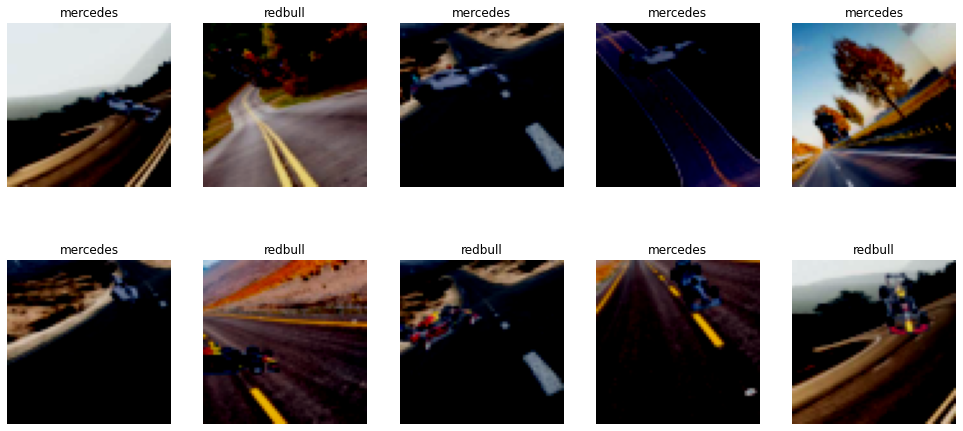

In [10]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize = (17, 8))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1)
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])
    plt.axis("off")

## Choosing a model
### Since training a rather large convolutional neural network from scratch would require alot of training examples and would've taken a significant amount of time, I have decided to take advantage of transfer learning. I went with the ResNet18, with pretrained weights from ImageNet, froze the convolutional base (except for the batch normalization layers) and substituted the final classifier layer to have 2 outputs. 
### It is arguably the best performing model I can fit in my GTX 1050Ti 4GB.

In [11]:
model = models.resnet18(pretrained = True)
for name, param in model.named_parameters():
    if("bn" not in name):
        param.requires_grad = False
model.fc = nn.Linear(in_features=512, out_features=2, bias=True)
model.to(CONFIG["DEVICE"]);

## The scaler is responsible for autocasting gradients to FP16 to speed up the training process. The optimizer, which is known to work well with ResNet is Adam, and the loss function is Cross Entropy with softmax activation included.

In [12]:
scaler = torch.cuda.amp.GradScaler()
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), 
lr=CONFIG["LEARNING_RATE"], 
weight_decay=CONFIG["WEIGHT_DECAY"])

## Define training loop

In [13]:
def train(
    model: torchvision.models, 
    train_loader: torch.utils.data.dataloader.DataLoader, 
    val_loader: torch.utils.data.dataloader.DataLoader, 
    loss_fn: torch.nn.modules.loss, 
    optimizer: torch.optim, 
    scaler: torch.cuda.amp.grad_scaler.GradScaler, 
    num_epochs: int):

    torch.cuda.empty_cache()
    history = []
    wandb.init(project="Computational Intelligence Project", entity="kwasniakk", config=CONFIG)
    wandb.watch(model)

    for epoch in tqdm(range(1, num_epochs), desc="Epochs"):
        train_metrics = EpochMetrics(
            len(train_loader), 
            phase="Training")

        model.train()
        training_loop = tqdm(train_loader, desc="Training", leave=False)
        for inputs, labels in training_loop:
            inputs, labels = inputs.to(CONFIG["DEVICE"]), labels.to(CONFIG["DEVICE"])

            with torch.cuda.amp.autocast():
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)

            optimizer.zero_grad()
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_metrics.update(loss, outputs, labels)
        training_loop.close()

        val_metrics = EpochMetrics(
            len(val_loader),
            phase="Validation")

        model.eval()
        validation_loop = tqdm(val_loader, desc="Validation", leave=False)
        with torch.no_grad():
            for val_inputs, val_labels in validation_loop:
                val_inputs, val_labels = val_inputs.to(CONFIG["DEVICE"]), val_labels.to(CONFIG["DEVICE"])

                val_outputs = model(val_inputs)
                val_loss = loss_fn(val_outputs, val_labels)

                val_metrics.update(val_loss, val_outputs, val_labels)
            validation_loop.close()

        single_epoch_metrics = {**train_metrics.to_dict(), **val_metrics.to_dict()}
        history.append(single_epoch_metrics)
        cms = get_confusion_matrix_matplotlib(single_epoch_metrics, classes)
        wandb.log(single_epoch_metrics, step=epoch) 
        wandb.log({f"Confusion Matrix nr.{epoch}": wandb.Image(cms)}, step=epoch)


    return history

In [14]:
history = train(model, train_loader, val_loader, loss, optimizer, scaler, CONFIG["NUM_EPOCHS"])

wandb: Currently logged in as: kino (use `wandb login --relogin` to force relogin)


Epochs:   0%|          | 0/49 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

Training:   0%|          | 0/250 [00:00<?, ?it/s]

Validation:   0%|          | 0/63 [00:00<?, ?it/s]

## Get the test set predictions

In [37]:
class TestDataset:
    def __init__(self, root, transform):
        self.root = root
        self.images = os.listdir(root) 
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        file = self.images[idx]
        raw_img = PIL.Image.open(os.path.join(self.root, file))
        img_transformed = self.transform(raw_img)
        return img_transformed, file

In [54]:
test_dataset = TestDataset("../data/f1-team-classification/test", transform=transforms_val)
test_loader = DataLoader(test_dataset, 
batch_size=CONFIG["BATCH_SIZE"], 
pin_memory=True)

In [65]:
model.eval()
image_ids = []
labels = np.zeros(0)
with torch.no_grad():
    for images, filenames in tqdm(test_loader):
        images = images.to(CONFIG["DEVICE"])
        output = model(images)
        _, preds = torch.max(output, 1)

        image_ids.extend(filenames)
        labels = np.concatenate((labels, preds.cpu().numpy()), axis=None)

  0%|          | 0/625 [00:00<?, ?it/s]

In [71]:
submission = pd.DataFrame({"ImageID": image_ids, "label": labels})
submission["label"] = submission["label"].apply(lambda x: classes[int(x)])
submission

ImageID     label
0     2288.jpg   redbull
1     5341.jpg   redbull
2     2123.jpg  mercedes
3     1280.jpg   redbull
4     1062.jpg   redbull
...        ...       ...
9995  7019.jpg   redbull
9996  8038.jpg  mercedes
9997  9512.jpg   redbull
9998  5426.jpg   redbull
9999  9887.jpg   redbull

[10000 rows x 2 columns]

## Export submission dataframe to csv format

In [73]:
submission.to_csv("../submission.csv", index=False)

## Finally, save the model for later purposes

In [76]:
torch.save(model, "../model_checkpoints/f1_model.pth")